In [224]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import *
import matplotlib.ticker as ticker
from tqdm import tqdm
from numba import njit
#np.random.seed(42)

plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.dpi"] = 100
plt.set_cmap("binary_r")

<Figure size 1400x800 with 0 Axes>

In [291]:
### 1.1 
n, m = 30, 30 # dimension of the grid
T = 10 # time steps

# Evolution rule: excited -> refractor -> rest (condition) -> excited
rest = 0
excited = 1 # generalize this to an arbitrary number
refractor = 2

# initial state, the boundaries are padded with infinities
s0 = np.infty * np.ones([n+2,m+2])
s0[1:-1,1:-1] = np.random.randint(0, 3, [n, m])
s = s0.copy()

results = np.zeros([T, n+2, m+2])
prev_states = []

@njit
def excite(s0, rest=rest, excited=excited): # rest -> excited according to some condition
    s = np.infty * np.ones_like(s0)
    for i in range(n+1):
        for j in range(m+1):
            if s0[i, j] == rest:
                # Stores the values of Von Neumann neighborhood around coordinate (i,j). 
                # This occurs for the previous state
                neighborhood = np.array([
                    s0[i-1, j], s0[i, j-1], s0[i, j+1], s0[i+1, j]
                ])
                
                # Checks if there is at least one excited state in the neighbor. 
                if np.sum(neighborhood == excited) >= 1:
                    s[i, j] = excited
                else:
                    s[i, j] = rest
            else:
                s[i, j] = s0[i, j]
    return s


### 1.2 and 3
# Loop for time evolution of the system
for t in tqdm(range(T)):
    results[t] = s0
    prev_states.append(s0.copy())
    
    # excitation with some condition
    s_excited = excite(s0)
    
    # unconditional transition
    s[s0 == excited] = refractor # excited -> refractor
    s[s0 == refractor] = rest # refractor -> rest
    
    # combine the results of the excitation and the unconditional transitions
    s = np.where(s0 == rest, s_excited, s)
    
    # Check for periodicity
    for i, prev_state in enumerate(prev_states):
        if np.allclose(s, prev_state):
            periodicity = t - i + 1
            print(f"After transient time {t=}, the system reached a periodic state with {periodicity=}.")
            break
    else:
        s0 = s # s0 is now the evolved state
        continue

    break

 50%|█████     | 5/10 [00:00<00:00, 18.86it/s]

After transient time t=5, the system reached a periodic state with periodicity=1.


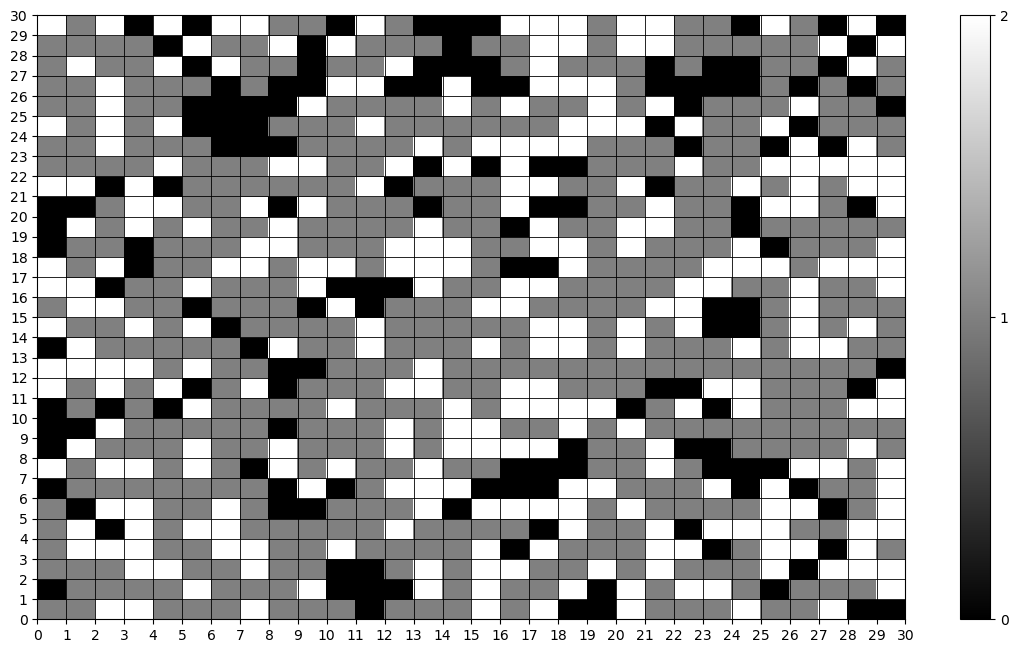

In [298]:
plt.pcolormesh(results[2][1:-1,1:-1], vmin=0, vmax=2)  
plt.colorbar(ticks=range(3))
plt.xticks(range(m+1)), plt.yticks(range(n+1))
plt.grid(lw=(n+m)/100, color="k")
plt.show()

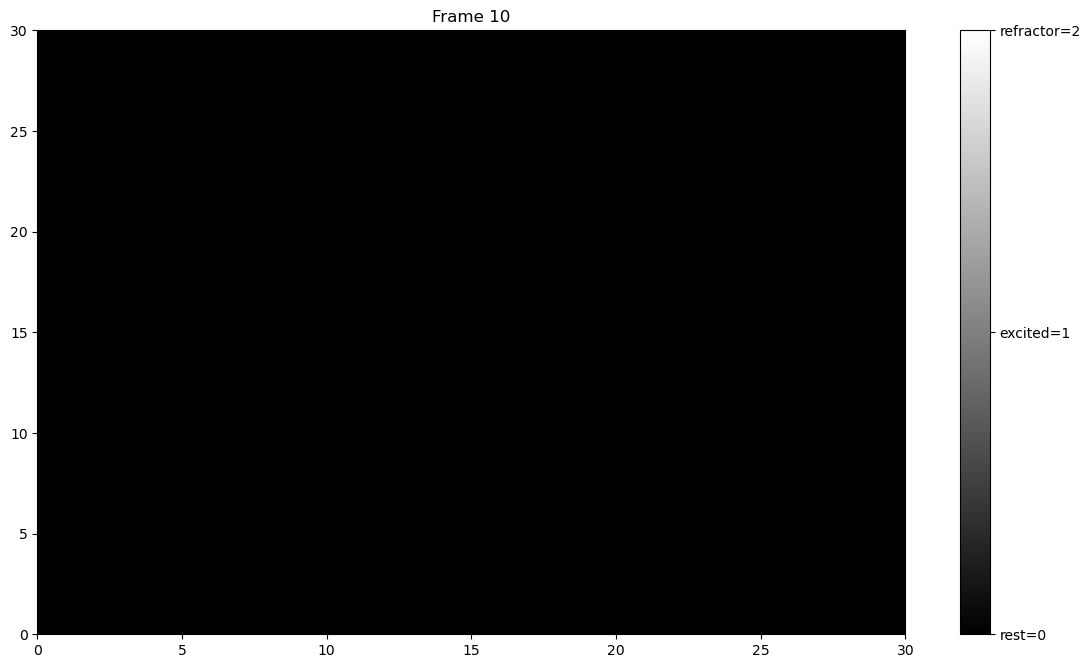

In [281]:
def update_plot(i, im, results):
    im.set_array(results[i][:-1,:-1])
    plt.title('Frame {}'.format(i+1))
    return [im]

def state_formatter(x, pos):
    states = [f"{rest=}", f"{excited=}", f"{refractor=}"]
    return states[int(x)]

def create_gif(results, filename, duration=100):
    fig = plt.figure()
    im = plt.pcolormesh(results[-1], animated=True, vmin=0, vmax=2)
    cbar = plt.colorbar(im, ticks=[0, 1, 2])
    cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(state_formatter))

    ani = FuncAnimation(fig, update_plot, frames=range(T), 
                        fargs=(im, results), interval=duration, blit=True)
    ani.save(filename, writer='pillow', fps=1)

create_gif(results, 'GHCA.gif', duration=100)